# Introduction to signal processing (Master Erasmus Mundus CYBER)


https://github.com/deepcharles/master-erasmus-mundus-cyber

This session is dedicated to change-point detection.

## 1. Library and data loading

In [1]:
from typing import List

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import librosa
import numpy as np
from IPython.display import Audio, display
import ruptures as rpt


In [17]:
def fig_ax(figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xmargin(0)
    return fig, ax

## Change-point detection on synthetic signals
Change point detection consists in finding the temporal boundaries of homogeneous portions of a signal.

The simplest (and oldest) change point detection methods deals with mean shifts.

#### Single change point
We start by trying to detect a single shift in mean (in a synthetic signal).


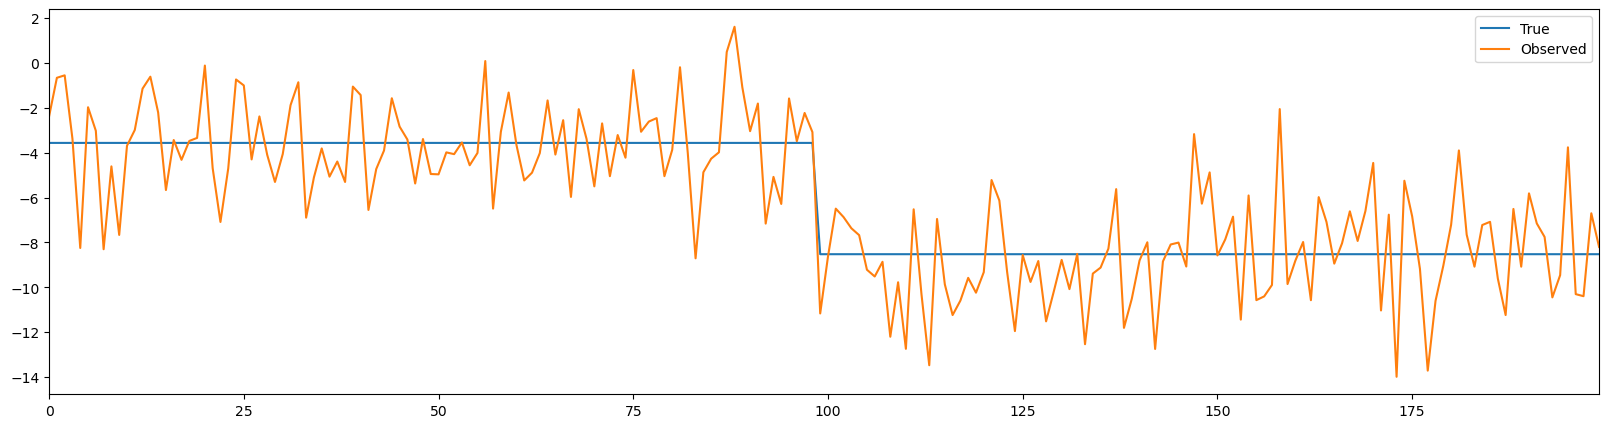

In [13]:
# generate signal
n_samples = 200
n_bkps = 1
n_dims = 1
sigma_noise = 2
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal_with_noise, label="Observed")
_ = plt.legend()

We fit the noisy signal with a piecewise constant function with a single discontinuity. The best fit is the function which minimizes the norm of the residuals.

For a $T$-sample signal $y$ and an index $a$, this amounts to:

$$
\sum_{t< a} \|y_t-\bar{y}_{0..a}\|^2 + \sum_{t\geq a} \|y_t-\bar{y}_{a..T}\|^2
$$

where $\bar{y}_{\text{left}}$ and $\bar{y}_{\text{right}}$ are the empirical means of $\{y_0,\dots,y_{a-1}\}$ and $\{y_a,\dots,y_{T-1}\}$ respectively.

The detection procedure consists in finding the index $a$ that minimizes this sum of costs.

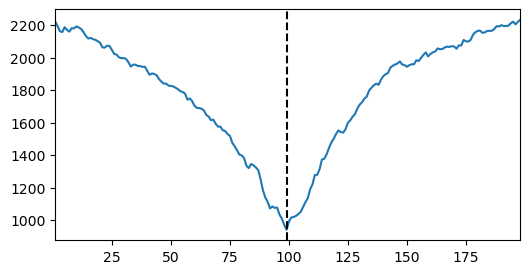

In [14]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = signal_with_noise[
        :mid_point
    ].var() * mid_point + signal_with_noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What happens to the sum of costs when the noise varies?</p>
    <p>And when the number of samples increases?</p>
</div>

#### Multiple change points (known $K$)

To extend the detection to more than one change, we simply some the costs of each segment defined by the $K$ change points $t_1,\dots,t_K$:

$$
\sum_{t=0}^{t_1-1} \|y_t-\bar{y}_{0..t_1}\|^2 + \sum_{t=t_1}^{t_2-1} \|y_t-\bar{y}_{t_1..t_2}\|^2 + \dots + \sum_{t=t_K}^{T-1} \|y_t-\bar{y}_{t_K..T}\|^2.
$$

We minimize over the $t_k$, using dynamic programming. (Other methods exists, e.g. binary segmentation, bottom-up, window-based, but are only approximate.)

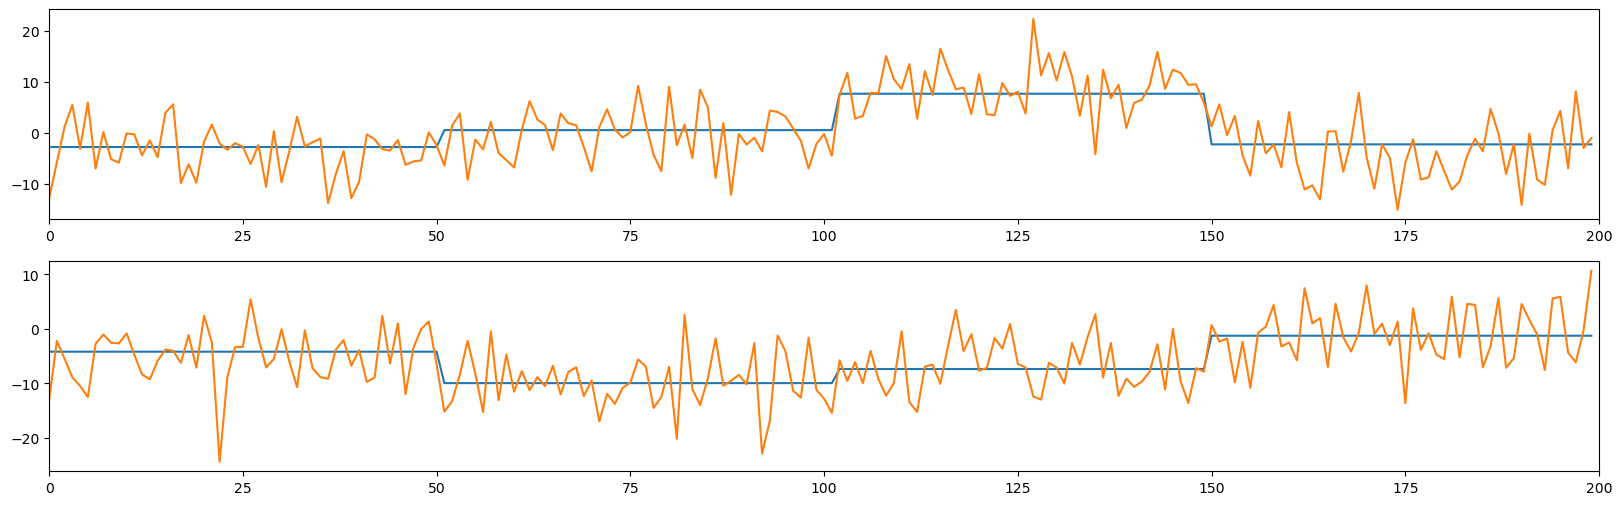

In [18]:
# generate signal
n_samples = 200
n_bkps = 3
n_dims = 2
sigma_noise = 5
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

# display
fig, ax_arr = plt.subplots(nrows=n_dims, figsize=(20, 3*n_dims))
for (signal1d, signal1d_with_noise, ax) in zip(
    signal.T, signal_with_noise.T, ax_arr
):
    ax.plot(signal1d)
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

Perform change point detection using dynamic programming.

In [19]:
algo = rpt.Dynp(model="l2", jump=1).fit(signal_with_noise)

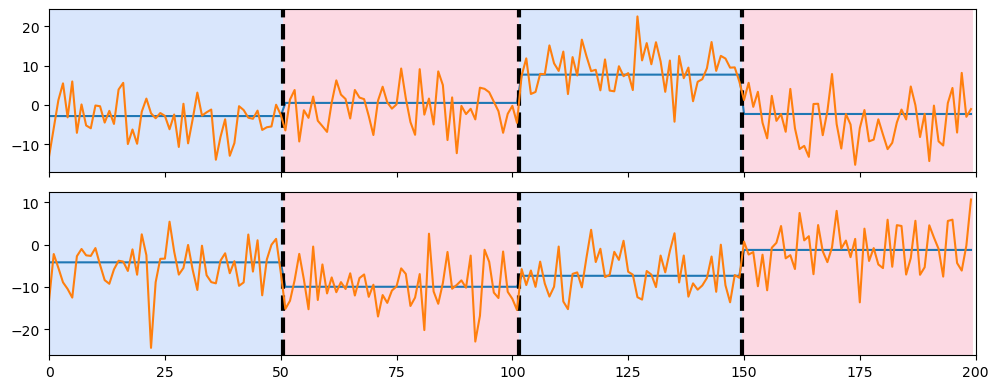

In [21]:
predicted_bkps = algo.predict(n_bkps=n_bkps)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
for (signal1d_with_noise, ax) in zip(signal_with_noise.T, ax_arr):
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Write a function that computes the approximation error for a given set of change-points.</p>
</div>

In [ ]:
def get_approximation_error(signal: NDArray, bkps: List) -> float:
    pass


In order to choose the number of change points, we use the elbow method. In the change point detection setting, this heuritic consists in:

- plotting the approximation error for 1, 2,..., $K_{\max}$ change-points,
- picking the number of changes at the "elbow" of the curve.

Intuitively, adding change points beyond the "elbow" only provides a marginal decrease of the sum of costs.
Here, we set $K_{\max}$:=20.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Implement the elbow heuristics.</p>
</div>

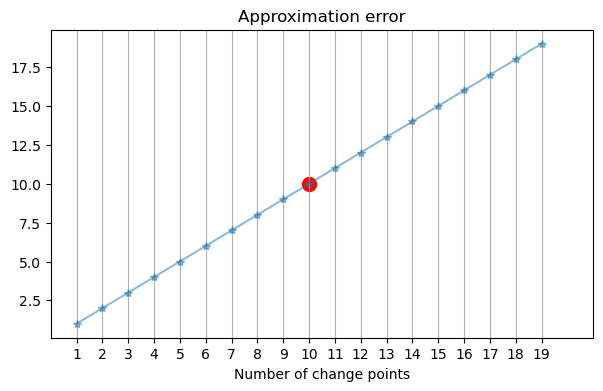

In [ ]:
n_bkps_max = 20  # K_max


###
# YOUR CODE HERE
list_of_approx_errors = np.arange(1, n_bkps_max)
###



fig, ax = fig_ax((7, 4))
ax.plot(
    np.arange(1, n_bkps_max),
    list_of_approx_errors,
    "-*",
    alpha=0.5,
)
ax.set_xticks(np.arange(1, n_bkps_max))
ax.set_xlabel("Number of change points")
ax.set_title("Approximation error")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

n_bkps = 10  # Change the value to change the location of the red dot
_ = ax.scatter(
    [n_bkps], [list_of_approx_errors[n_bkps-1]], color="r", s=100
)


## Change-point detection on audio signals

In this tutorial, we choose the *Dance of the Sugar Plum Fairy* from *The Nutcracker* by Tchaikovsky.

We can listen to the music as well as display the sound envelope.

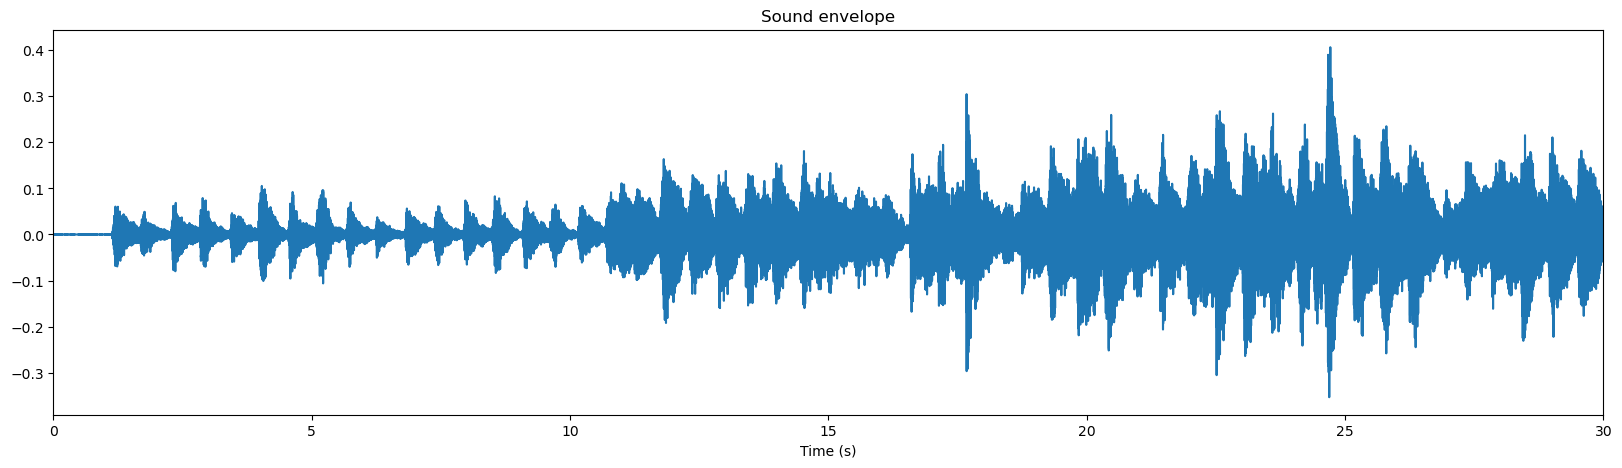

In [5]:
duration = 30  # in seconds
signal, sampling_rate = librosa.load(librosa.ex("nutcracker"), duration=duration)

# listen to the music
display(Audio(data=signal, rate=sampling_rate))

# look at the envelope
fig, ax = fig_ax()
ax.plot(np.arange(signal.size) / sampling_rate, signal)
ax.set_xlim(0, signal.size / sampling_rate)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

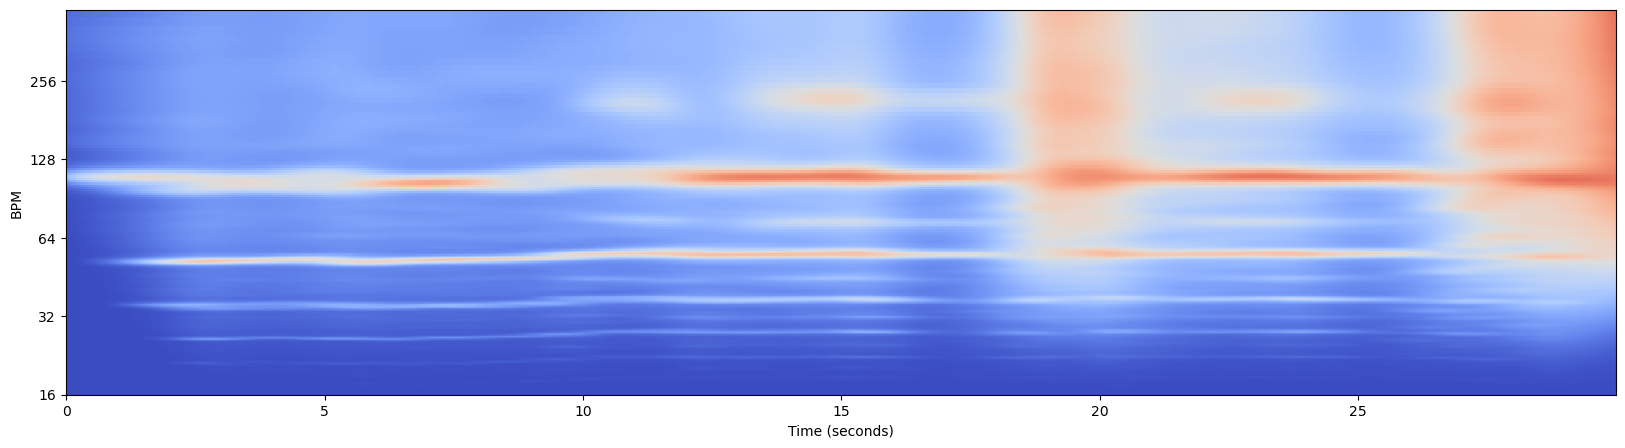

In [6]:
def get_tempogram(signal: NDArray, fs: int, hop_length: int) -> NDArray:
    # Compute the onset strength
    oenv = librosa.onset.onset_strength(y=signal, sr=fs, hop_length=hop_length)
    # Compute the tempogram
    tempogram = librosa.feature.tempogram(
        onset_envelope=oenv,
        sr=sampling_rate,
        hop_length=hop_length,
    )
    return tempogram

hop_length = 256
tempogram = get_tempogram(
    signal=signal, fs=sampling_rate, hop_length=hop_length
)

# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length,
    sr=sampling_rate,
    x_axis="s",
    y_axis="tempo",
)


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the dimensions of the tempogram? How many timestamps and how many BPMs?</p>
    <p>Here, the tempogram is computed with a sliding window of 384 samples and a jump of 256 samples between window. What is the expected tempogram length?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Perform change-point detection on the tempogram with 10 change-points. What are the change-points?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Using the elbow heuristics, find the optimal number of change-points (take `K_max=20`).</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the final change-points? Convert the indexes in seconds.</p>
</div>

In [ ]:
bkps_times = ...  # put the estimated change-points, converted in seconds.

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sampling_rate,
)

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

Visually, the estimated change points indeed separate portions of signal with a relatively constant tempo profile. Going back to the original music signal, this intuition can be verified by listening to the individual segments defined by the changes points.

In [ ]:
# Compute change points corresponding indexes in original signal
bkps_time_indexes = (sampling_rate * bkps_times).astype(int).tolist()

for segment_number, (start, end) in enumerate(
    rpt.utils.pairwise([0] + bkps_time_indexes), start=1
):
    segment = signal[start:end]
    print(f"Segment n°{segment_number} (duration: {segment.size/sampling_rate:.2f} s)")
    display(Audio(data=segment, rate=sampling_rate))
